In [17]:
from PIL import Image
import pandas as pd 
import os
import numpy as np 
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid import ImageGrid
from sklearn.model_selection import train_test_split
# local module import
from preprocessing import load_dataset

In [2]:
# Path to all data
DATA_PATH = "../dataset_mri/lgg-mri-segmentation/kaggle_3m/"
IMG_SIZE=224
dataset=load_dataset(DATA_PATH)
dataset.head()

patient_id  \
0  TCGA_CS_4941_19960909_16   
1  TCGA_CS_4941_19960909_22   
2   TCGA_CS_4941_19960909_1   
3  TCGA_CS_4941_19960909_10   
4  TCGA_CS_4941_19960909_11   

                                          image_path  \
0  ../dataset_mri/lgg-mri-segmentation/kaggle_3m/...   
1  ../dataset_mri/lgg-mri-segmentation/kaggle_3m/...   
2  ../dataset_mri/lgg-mri-segmentation/kaggle_3m/...   
3  ../dataset_mri/lgg-mri-segmentation/kaggle_3m/...   
4  ../dataset_mri/lgg-mri-segmentation/kaggle_3m/...   

                                          image_data  \
0  [[2, 2, 3, 4, 2, 2, 1, 1, 3, 3, 2, 3, 3, 3, 3,...   
1  [[4, 2, 1, 0, 1, 4, 6, 4, 3, 3, 3, 3, 4, 3, 2,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [[2, 3, 3, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 3, 4,...   
4  [[1, 1, 2, 2, 3, 2, 4, 3, 3, 3, 2, 2, 2, 3, 5,...   

                                           mask_path  \
0  ../dataset_mri/lgg-mri-segmentation/kaggle_3m/...   
1  ../dataset_mri/lgg-mri-segmentation/kaggle_3m/...   
2  ../dataset_mri/lgg-mri-segmentation/kaggle_3m/...   
3  ../dataset_mri/lgg-mri-segmentation/kaggle_3m/...   
4  ../dataset_mri/lgg-mri-segmentation/kaggle_3m/...   

                                           mask_data  tumor  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      1  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      0  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      0  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      0  
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      1

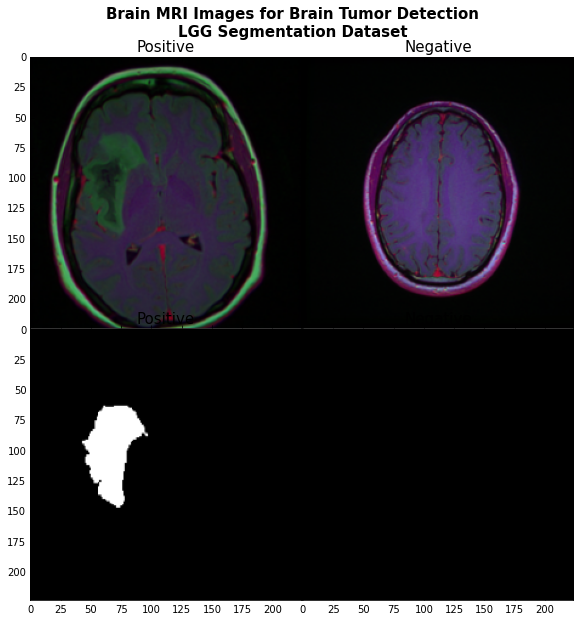

In [4]:
# Data
sample_yes_df = dataset[dataset["tumor"] == 1].sample(2)
sample_no_df = dataset[dataset["tumor"] == 0].sample(2)
image_yes = sample_yes_df.image_path.values
image_no= sample_no_df.image_path.values
mask_yes = sample_yes_df.mask_path.values
mask_no= sample_no_df.mask_path.values

sample_imgs = []
for i, (yes, no,yes_mask,no_mask) in enumerate(zip(image_yes, image_no, mask_yes, mask_no)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    yes_mask= cv2.resize(cv2.imread(yes_mask), (IMG_SIZE, IMG_SIZE))
    no_mask= cv2.resize(cv2.imread(no_mask), (IMG_SIZE, IMG_SIZE))

# Plot
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2))

#MR Images
grid[0].imshow(yes)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(no)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")
#Mask corresponding
grid[2].imshow(yes_mask)
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(no_mask)
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")
# annotations
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=15, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

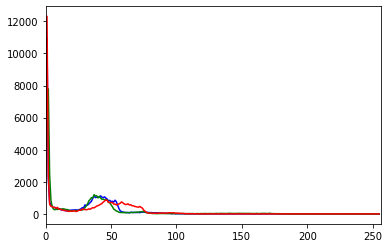

In [5]:
def calculhisto(I,color):
    for i,col in enumerate(color):
        histr = cv2.calcHist([I],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.show()
    
    
hist = calculhisto(yes,('b','g','r'))

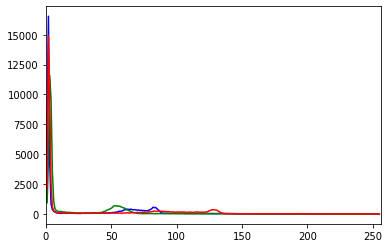

In [6]:
hist = calculhisto(no,('b','g','r'))

In [9]:
img = cv2.imread("../dataset_mri/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif")

In [10]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

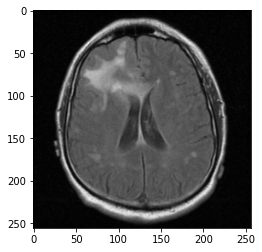

In [11]:
plt.imshow(gray, cmap='gray')

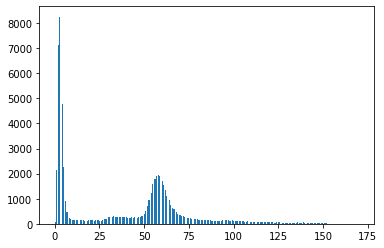

In [12]:
plt.hist(gray.ravel(),256)
plt.show()

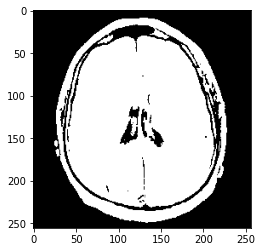

In [13]:
#Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

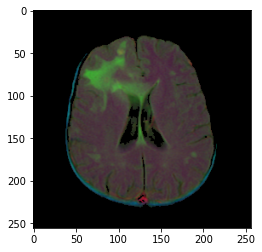

In [14]:
ret, markers = cv2.connectedComponents(thresh)

#Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
#Get label of largest component by area
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
#Get pixels which correspond to the brain
brain_mask = markers==largest_component

brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out[brain_mask==False] = (0,0,0)
plt.imshow(brain_out)

(-0.5, 255.5, 255.5, -0.5)

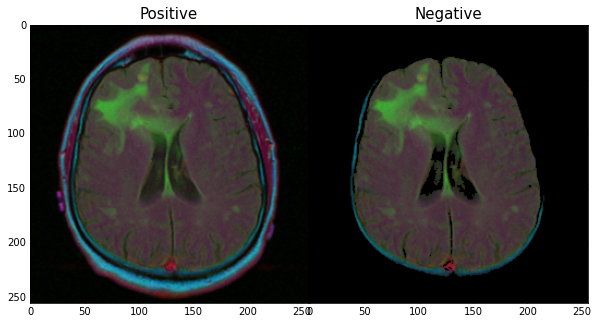

In [16]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2))

#MR Images
grid[0].imshow(img)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(brain_out)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

In [33]:
def otsu_skull_stripping(img, display=True):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #Threshold the image to binary using Otsu's method
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
    
    if display:
        plt.imshow(thresh, cmap='gray')
    
    ret, markers = cv2.connectedComponents(thresh)

    #Get the area taken by each component. Ignore label 0 since this is the background.
    marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 

    if marker_area:
        #Get label of largest component by area
        largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above

        #Get pixels which correspond to the brain
        brain_mask = markers==largest_component

        brain_out = img.copy()
        #In a copy of the original image, clear those pixels that don't correspond to the brain
        brain_out[brain_mask==False] = (0,0,0)
    else:
        brain_out = img.copy()
    
    if display:
        plt.imshow(brain_out)

        fig = plt.figure(figsize=(10., 10.))
        grid = ImageGrid(fig, 111, nrows_ncols=(1, 2))

        #MR Images
        grid[0].imshow(img)
        grid[0].set_title("Initial image", fontsize=15)
        grid[0].axis("off")
        grid[1].imshow(brain_out)
        grid[1].set_title("Stripped image", fontsize=15)
        grid[1].axis("off")
    
    return brain_out

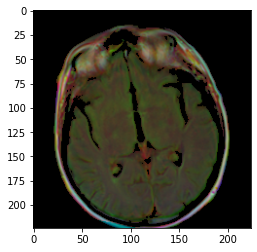

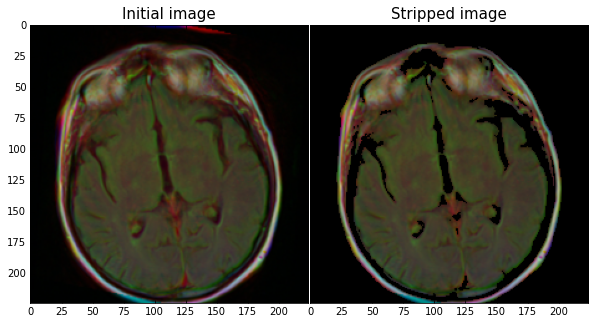

In [42]:
random_image_path = dataset.sample(1).image_path.values[0]
img = cv2.resize(cv2.imread(random_image_path), (IMG_SIZE, IMG_SIZE))
brain_out = otsu_skull_stripping(img)

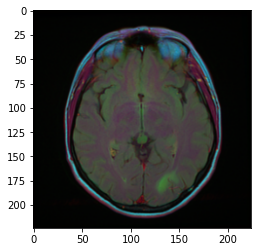

In [120]:
random_image_path = dataset.sample(1).image_path.values[0]
img = cv2.resize(cv2.imread(random_image_path), (IMG_SIZE, IMG_SIZE))
plt.imshow(img)

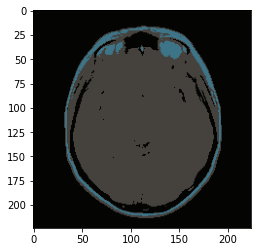

In [124]:
# Try k-means algorithm
reshaped_img = img.reshape((-1, 3))
reshaped_img = np.float32(reshaped_img)

# Criteria definition
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
nb_clusters = 3
ret, label, center=cv2.kmeans(reshaped_img, nb_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Extract new image
center = np.uint8(center)
res = center[label.flatten()]
k_means_img = res.reshape((img.shape))

plt.imshow(k_means_img)

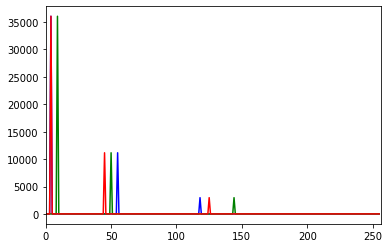

In [69]:
hist = calculhisto(k_means_img,('b','g','r'))

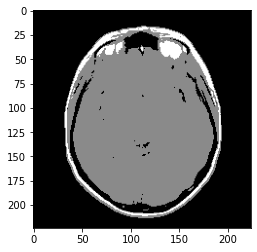

In [125]:
gray_k_means_img = cv2.cvtColor(k_means_img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray_k_means_img, cmap='gray')

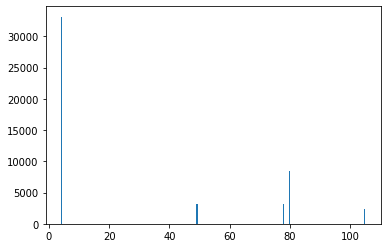

In [115]:
plt.hist(gray_k_means_img.ravel(),256)
plt.show()

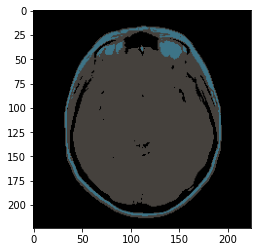

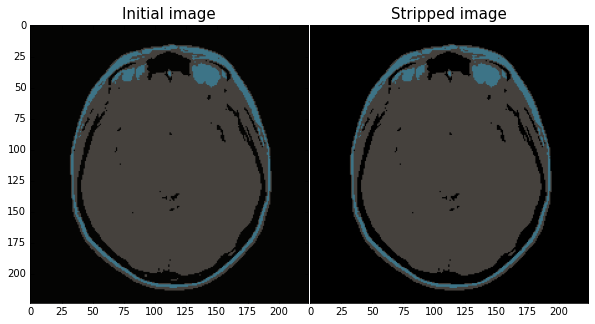

In [126]:
brain_out = otsu_skull_stripping(k_means_img)

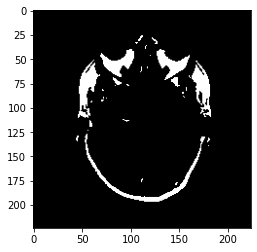

In [99]:
ret, thresh = cv2.threshold(gray_k_means_img, 80,255,cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')

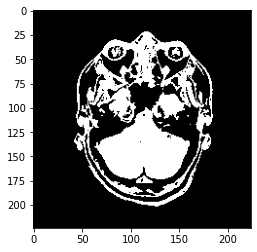

In [93]:
filtered_img = gray_k_means_img
filtered_img[filtered_img < 40] = 0
filtered_img[filtered_img > 80] = 0
plt.imshow(filtered_img, cmap='gray')

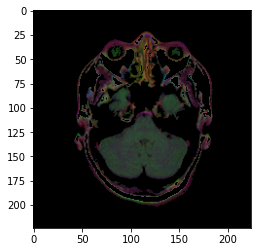

In [100]:
ret, markers = cv2.connectedComponents(filtered_img)

#Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
#Get label of largest component by area
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
#Get pixels which correspond to the brain
brain_mask = markers==largest_component

brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out[brain_mask==False] = (0,0,0)
plt.imshow(brain_out)

# Gif generation

In [19]:
import glob
import imageio
import IPython.display as ipdisplay

In [20]:
# filepaths
fp_in = DATA_PATH + "TCGA_CS_4941_19960909/*[0-9].tif"
fp_out = "./gifs/test.gif"
filenames = [f for f in sorted(glob.glob(fp_in))]
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./gifs/test.gif', images, duration=0.75)

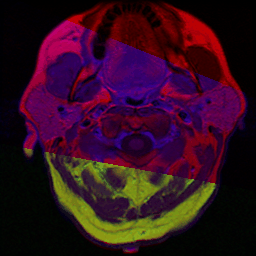

In [21]:
ipdisplay.Image("./gifs/test.gif")

In [34]:
def generate_gif_from_directory(directory_path, output_filename):
    files_regex = directory_path + "*[0-9].tif"
    filenames = [f for f in sorted(glob.glob(files_regex))]
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(output_filename, images, duration=0.75)

def generate_gif_from_images(images, output_filename):
    imageio.mimsave(output_filename, images, duration=0.75)

# Determining simple otsu treshold performance

In [35]:
images_regex = DATA_PATH + "TCGA_CS_4941_19960909/*[0-9].tif"
filenames = [f for f in sorted(glob.glob(images_regex))]
images = []
for filename in filenames:
    img = cv2.resize(cv2.imread(filename), (IMG_SIZE, IMG_SIZE))
    brain_out = otsu_skull_stripping(img, display=False)
    images.append(cv2.cvtColor(brain_out, cv2.COLOR_BGR2RGB))

generate_gif_from_images(images, "./gifs/patient_1_brain_out.gif")

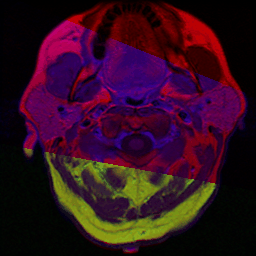

In [38]:
ipdisplay.Image("./gifs/test.gif")

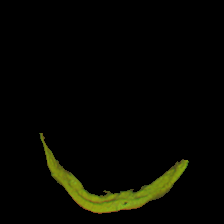

In [39]:
ipdisplay.Image("./gifs/patient_1_brain_out.gif")